### Disclaimer

Distribution authorized to U.S. Government agencies and their contractors. Other requests for this document shall be referred to the MIT Lincoln Laboratory Technology Office.

This material is based upon work supported by the Under Secretary of Defense for Research and Engineering under Air Force Contract No. FA8702-15-D-0001. Any opinions, findings, conclusions or recommendations expressed in this material are those of the author(s) and do not necessarily reflect the views of the Under Secretary of Defense for Research and Engineering.

© 2019 Massachusetts Institute of Technology.

The software/firmware is provided to you on an As-Is basis

Delivered to the U.S. Government with Unlimited Rights, as defined in DFARS Part 252.227-7013 or 7014 (Feb 2014). Notwithstanding any copyright notice, U.S. Government rights in this work are defined by DFARS 252.227-7013 or DFARS 252.227-7014 as detailed above. Use of this work other than as specifically authorized by the U.S. Government may violate any copyrights that exist in this work.


In [1]:
from tesse.env import Env
from tesse.msgs import *

import time
import matplotlib.pyplot as plt

In [2]:
env = Env(simulation_ip='localhost', own_ip='localhost', position_port=9000, metadata_port=9001, image_port=9002)

### Demo Transform Message

In [3]:
env.send(Transform(-1, 0, 0)) # left
time.sleep(1)
env.send(Transform(1, 0, 0)) # right
time.sleep(1)
env.send(Transform(0, -1, 0)) # back
time.sleep(1)
env.send(Transform(0, 1, 0)) # forward
time.sleep(1)
env.send(Transform(0, 0, 45)) # turn right
time.sleep(1)
env.send(Transform(0, 0, -45)) # turn left

### Demo Force and Torque Message

In [4]:
env.send(AddRelativeForceAndTorque(100, 0)) # Forward force
time.sleep(1)
env.send(AddRelativeForceAndTorque(-100, 0)) # Backward force
time.sleep(1)
env.send(AddRelativeForceAndTorque(0, 10)) # Torque right
time.sleep(1)
env.send(AddRelativeForceAndTorque(0, -10)) # Torque left

### Demo Reposition Message

In [5]:
env.send(Reposition(-18, 14, 24, 0, 0, 0, 0))
time.sleep(1)
env.send(Reposition(-17, 2, 25, 0, 0, 0, 0))

### Demo getting images

In [6]:
def plot(response, title=None):
    if len(response.images) == 0:
        return
    figsize = (len(response.images)*5, 5)
    fig, axs = plt.subplots(1, len(response.images), figsize=figsize)
    if len(response.images) > 1:
        for ax, img in zip(axs, response.images):
            ax.axis('off');
            ax.imshow(img, cmap='gray');
    else:
        axs.axis('off');
        axs.imshow(response.images[0], cmap='gray');
        axs.set_title(title)

<TESSE Agent Metadata v0.2>
  <position x='-17' y='2.362615' z='25'/>
  <quaternion x='0' y='0' z='0' w='1'/>
  <velocity x_dot='0' y_dot='0.00311133' z_dot='0'/>
  <angular velocity x_ang_dot='0' y_ang_dot='0' z_ang_dot ='0'/>
  <acceleration x_ddot='0' y_ddot='-0.1112182' z_ddot='0'/>
  <angular acceleration x_ang_ddot='0' y_ang_ddot='0' z_ang_ddot='0'/>
  <time>29.37282</time>
  <collision status='false' name=''/>
</TESSE Agent Metadata v0.2>



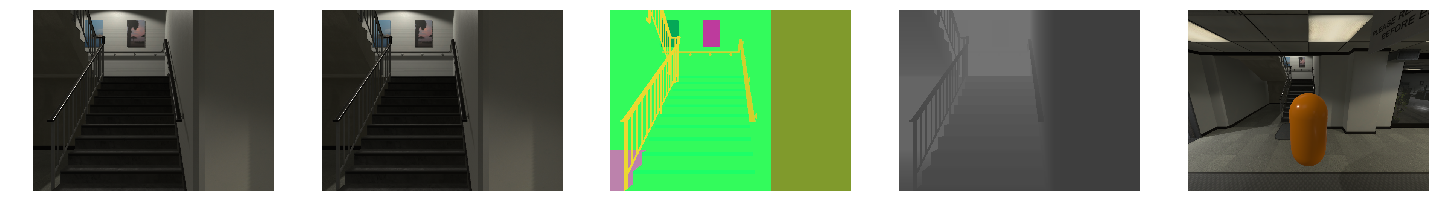

In [7]:
response = env.request(DataRequest())
if response is not None:
    print(response.data)
    plot(response)

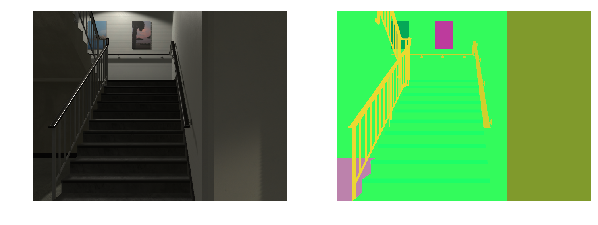

In [8]:
cameras=[
    (Camera.RGB_LEFT, Compression.ON, Channels.THREE),
    (Camera.SEGMENTATION, Compression.OFF, Channels.THREE),
]
response = env.request(DataRequest(metadata=False, cameras=cameras))
if response is not None:
    plot(response)

### Metadata request

In [9]:
response = env.request(MetadataRequest())
if response is not None:
    print(response.data)

<TESSE Agent Metadata v0.2>
  <position x='-17' y='2.362731' z='25'/>
  <quaternion x='0' y='0' z='0' w='1'/>
  <velocity x_dot='0' y_dot='0.001060217' z_dot='0'/>
  <angular velocity x_ang_dot='0' y_ang_dot='0' z_ang_dot ='0'/>
  <acceleration x_ddot='0' y_ddot='-0.3473875' z_ddot='0'/>
  <angular acceleration x_ang_ddot='0' y_ang_ddot='0' z_ang_ddot='0'/>
  <time>45.42</time>
  <collision status='false' name=''/>
</TESSE Agent Metadata v0.2>



### Camera request

In [10]:
response = env.request(CameraInformationRequest())
if response is not None:
    print(response.data)

<camera_info>
  <name></name>
  <id>0</id>
  <parameters height='0' width='0'fov='37.84929'/>
  <position x='-0.05' y='0' z='0'/>
  <rotation x='0' y='0' z='0' w='1'/>
</camera_info>
<camera_info>
  <name></name>
  <id>1</id>
  <parameters height='0' width='0'fov='37.84929'/>
  <position x='0.05' y='0' z='0'/>
  <rotation x='0' y='0' z='0' w='1'/>
</camera_info>
<camera_info>
  <name></name>
  <id>2</id>
  <parameters height='0' width='0'fov='37.84929'/>
  <position x='0.05' y='0' z='0'/>
  <rotation x='0' y='0' z='0' w='1'/>
</camera_info>
<camera_info>
  <name></name>
  <id>3</id>
  <parameters height='0' width='0'fov='37.84929'/>
  <position x='0.05' y='0' z='0'/>
  <rotation x='0' y='0' z='0' w='1'/>
</camera_info>
<camera_info>
  <name></name>
  <id>4</id>
  <parameters height='0' width='0'fov='90'/>
  <position x='0' y='1.319' z='-2.258'/>
  <rotation x='0.1100685' y='0' z='0' w='0.993924'/>
</camera_info>



### Demonstrate some camera manipulation

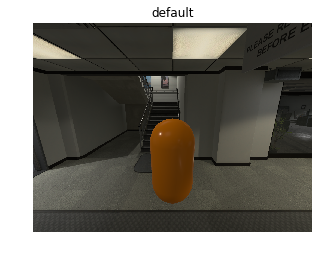

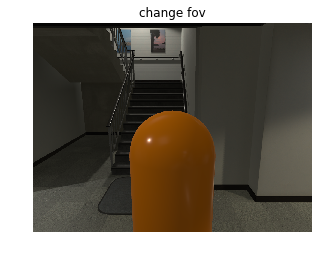

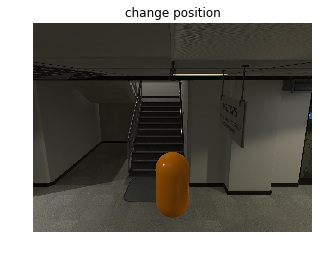

In [11]:
# Reset 3rd person view to default
_ = env.request(SetCameraParametersRequest(768, 1024, 90, Camera.THIRD_PERSON))
_ = env.request(SetCameraPositionRequest(0, 1.319, -2.258, Camera.THIRD_PERSON))
response = env.request(DataRequest(cameras=[(Camera.THIRD_PERSON, Compression.OFF, Channels.THREE)]))
if response is not None:
    plot(response, 'default')

# Change the parameters and get the camera
_ = env.request(SetCameraParametersRequest(768, 1024, 55, Camera.THIRD_PERSON))
response = env.request(DataRequest(cameras=[(Camera.THIRD_PERSON, Compression.OFF, Channels.THREE)]))
if response is not None:
    plot(response, 'change fov')


# Change the position and get the camera
_ = env.request(SetCameraPositionRequest(0, 3, -5.5, Camera.THIRD_PERSON))
response = env.request(DataRequest(cameras=[(Camera.THIRD_PERSON, Compression.OFF, Channels.THREE)]))
if response is not None:
    plot(response, 'change position')

### Demo respawning

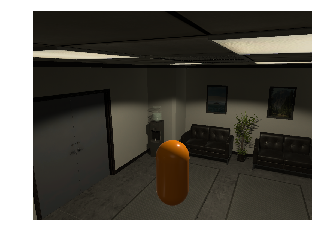

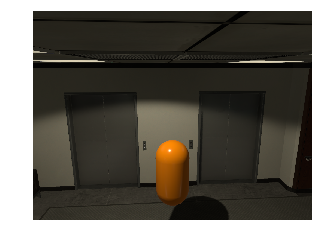

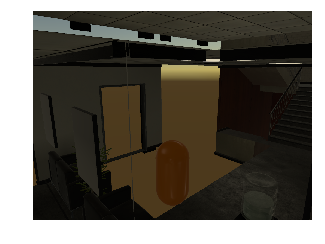

In [12]:
for i in range(3):
    env.send(Respawn())
    response = env.request(DataRequest(cameras=[(Camera.THIRD_PERSON, Compression.OFF, Channels.THREE)]))
    if response is not None:
        plot(response)
    time.sleep(1)

### Demo changing scenes

*NOTE: loading scenes for the first time may take a long time*

In [14]:
scene_index = 0

response = env.request(SceneRequest(scene_index))
if response is not None:
    print(response.data)

<current_scene>
  <index>0</index>
  <name>tesse_multiscene_v0.2_interface_test</name>
</current_scene>

